
<h1 id="Introduction-to-OpenCV">Introduction to OpenCV<a class="anchor-link" href="#Introduction-to-OpenCV">¶</a></h1><p>This jupyter notebook gets you started with OpenCV. It introduces the basics you will need to perform the analysis of the data you captured last week. It is not comprehensive with respect to the methods you need to use to track the flies centroids and heading direction. For additional methods refere to last weeks presentation and OpenCV's documentation online.</p>
<h2 id="Installation">Installation<a class="anchor-link" href="#Installation">¶</a></h2><p>You can test if you have all the necessary packages installed by running the cell below. Should you receive any import errors you can use pip to install the missing package. Try the following commands to do that:<br/>
<code>pip install opencv_python</code> or <code>python -m pip install opencv_python</code><br/>
<code>pip install numpy</code> or <code>python -m pip install numpy</code><br/>
<code>pip install matplotlib</code> or <code>python -m pip install matplotlib</code></p>


In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
# This line is necessary to show the images inside the jupyter notebook.
%matplotlib inline


<p>First, we need to load an image from file.</p>


In [279]:
img = cv2.imread('img_5.jpg')


<p>The returned image is a numpy array of data type uint8.</p>


In [280]:
print(type(img))
print(img.dtype)

<class 'numpy.ndarray'>
uint8



<p>We know our image is a gray scale image so we can convert it from RGB representation.</p>


In [281]:
print(img.shape)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print(img.shape)

(480, 640, 3)
(480, 640)



<p>To display the image, you can use matplotlib or OpenCV if you are not working in a jupyter notebook.<br/>
(OpenCV:<code>cv2.imshow('image',img); cv2.waitKey(0)</code>)</p>


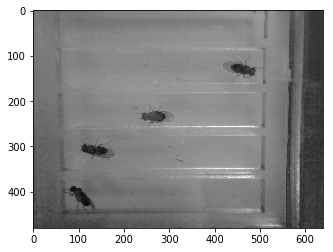

In [282]:
plt.imshow(img, cmap='gray')

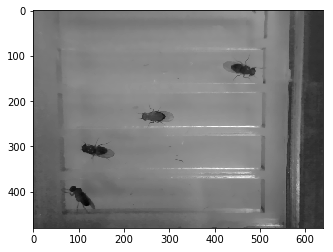

In [283]:
kernel = np.ones((5,5),np.float32)/25
#filt = cv2.filter2D(img,-1,kernel)
#filt = cv2.medianBlur(img,5)
#filt = cv2.bilateralFilter(img,7,30,30)
#filt = cv2.bilateralFilter(img,13,30,30)
filt = cv2.bilateralFilter(img,15,5,5)
plt.imshow(filt, cmap='gray')
plt.show()

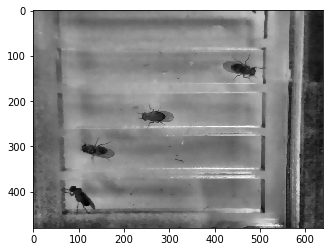

In [284]:
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
cl = clahe.apply(filt)
plt.imshow(cl, cmap='gray')
plt.show()

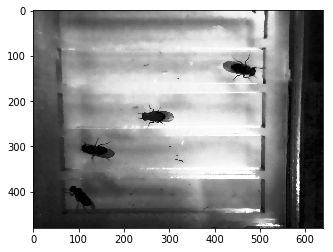

In [285]:
equ = cv2.equalizeHist(filt)
plt.imshow(equ, cmap='gray')
plt.show()

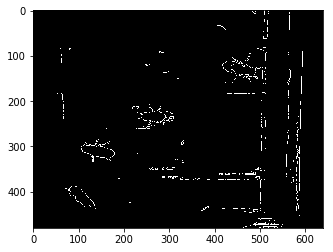

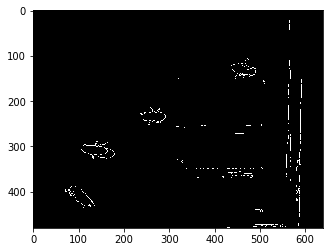

In [286]:
edge = cv2.Canny(equ,100,250)
edge_o = cv2.Canny(img,100,200)
plt.imshow(edge, cmap='gray')
plt.show()
plt.imshow(edge_o, cmap='gray')
plt.show()


<p>Next, we will apply a binary thereshold to the image using OpenCV.</p>


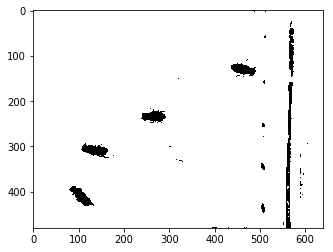

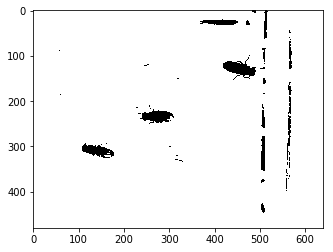

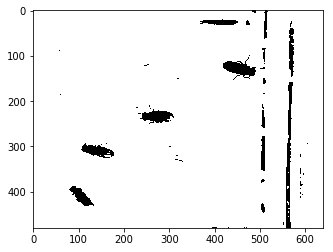

In [301]:
#ret, mask = cv2.threshold(equ, 120, 255, cv2.THRESH_BINARY)
mask2 = cv2.adaptiveThreshold(equ, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 195, 60)
mask1 = cv2.adaptiveThreshold(filt, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 195, 25)
plt.imshow(mask1, cmap='gray')
plt.show()
plt.imshow(mask2, cmap='gray')
plt.show()
plt.imshow(255 - (255-mask1) - (255-mask2), cmap='gray')
plt.show()

In [302]:
mask2 = 255 - (255-mask1) - (255-mask2)

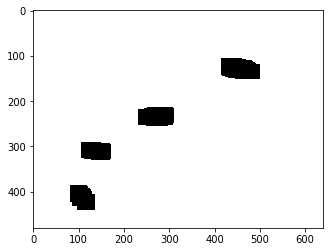

In [322]:
kernel_co = np.ones((15,15),np.uint8)
kernel_dil = np.ones((20,25),np.uint8)
closing = cv2.morphologyEx(mask2, cv2.MORPH_CLOSE, kernel_co)
opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel_co)
dilation = cv2.erode(opening, kernel_dil, 100)
plt.imshow(dilation, cmap='gray')
plt.show()

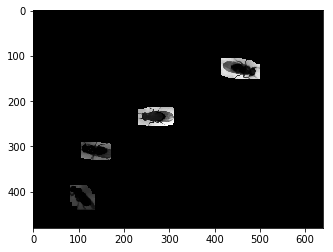

In [323]:
mask = 255 - dilation
outcome = cv2.bitwise_and(equ, equ, mask=mask)
plt.imshow(outcome, cmap='gray')
plt.show()

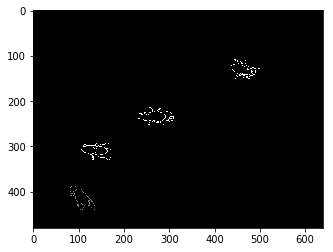

In [324]:
edge1 = cv2.Canny(filt,20,255)
edge = edge1 * mask
plt.imshow(edge, cmap='gray')
plt.show()

[[     0]
 [     1]
 [     2]
 ...
 [307197]
 [307198]
 [307199]]
(480, 640)


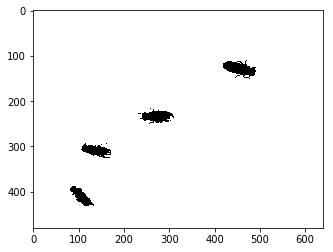

In [325]:
mask3 = mask2
ids = np.argwhere(mask.flatten() == 0)
print(ids)
mask3_fl = mask3.flatten()
mask3_fl[ids] = 255
mask3_fl = mask3_fl.reshape(mask.shape[0], -1)
print(mask3_fl.shape)
#plt.scatter(ids.T[1], ids.T[0])
plt.imshow(mask3_fl, cmap='gray')
plt.show()

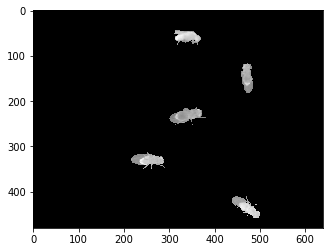

In [253]:
img1 = img * (255-mask3_fl)
plt.imshow(img1, cmap='gray')
plt.show()

In [239]:
th = mask3_fl

In [240]:
#circular kernel
kernel = np.ones((5,5),np.uint8)
for i in [0,4]:
    for j in [0,4]:
        kernel[i,j] = 0
        kernel[j,i] = 0

#contour
con = edge.copy()
_, contours, hierarchy = cv2.findContours(con,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
con = cv2.drawContours(con, contours, -1, (255,25,25), 6)

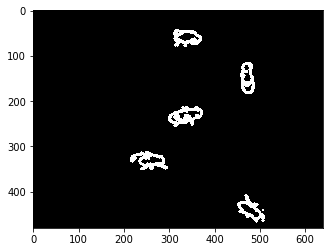

In [241]:
plt.imshow(con, cmap='gray')
plt.show()

In [242]:
#morphology filters
#th = cv2.morphologyEx(th,cv2.MORPH_OPEN, kernel)

#filling edges image to get centers of flies
h, w = th.shape[:2]
mask = np.zeros((h+2, w+2), np.uint8)

fill = con.copy()
cv2.floodFill(fill, mask, (0,0), 255)

#dilate to get better shape of flies
fill = cv2.dilate(fill,kernel,iterations = 1)
fill = cv2.erode(fill,kernel,iterations = 2)

#remove lines
y_size = fill.shape[0]
x_size = fill.shape[1]
lines = fill.copy()/255
for x in range(x_size):
    if np.sum(lines[:,x])<(y_size*0.85):
        lines[:,x-12:x+12] = np.ones((y_size,24))
for y in range(y_size):
    if np.sum(lines[y,:])<(x_size*0.75):
        lines[y-12:y+12,:] = np.ones((24,x_size))
lines = lines*255

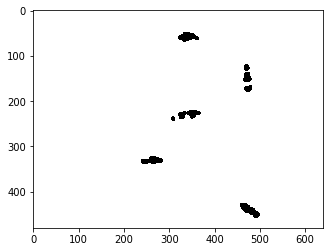

In [243]:
plt.imshow(lines, cmap='gray')
plt.show()


<p>We have to invert the image because the flies are our ROIs and not the background.</p>



<p>To analyze connected components in a binary image you can use OpenCV's connectedComponentsWithStats function.</p>


In [29]:
output = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)

In [30]:
label_img = output[1].astype(np.uint8)
centroids = output[3]
sizes = output[2][:, 4]
largest_ids = np.argsort(sizes)[::-1][:7]
largest = centroids[largest_ids]

In [31]:
sizes[largest_ids]

array([161929, 144062,    676,    288,     94,     87,     22],
      dtype=int32)

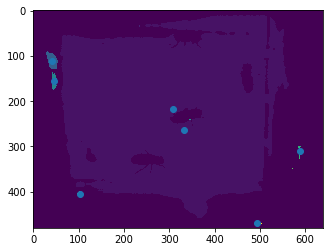

In [32]:
plt.imshow(label_img)
plt.scatter(largest.T[0], largest.T[1])
plt.show()

In [ ]:
print('Centroids', output[3])
print('Sizes', output[2][:, 4])